In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [45]:
import bootstrap
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
import tensorflow as tf
import tensorflow.keras as keras
import tf_utils as tfu
from scipy.spatial import KDTree
from scipy import stats
import wandb

from common.models import dnabert, dnagast, gast
from common.metrics import chamfer_distance_matrix, chamfer_distance_extend_matrix, mds, mds_stress_analysis
from common.data import find_dbs, DnaSampleGenerator, DnaLabelType
from common.utils import plt_to_image

## Configuration

In [105]:
N = 10 # Number of groups for confidence intervals
control_subsamples_per_sample = 10
test_subsamples_per_sample = 10

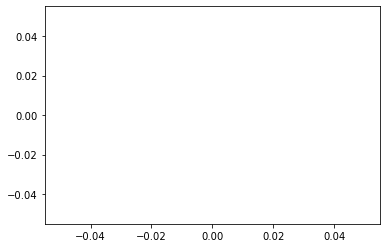

In [4]:
# Must plot before changing config otherwise plots won't display...
plt.plot([], [])

In [5]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [6]:
strategy = tfu.strategy.gpu(0)

## Connect to W&B

In [7]:
api = wandb.Api()

## Fetch DNABERT Model

Here we download the DNABERT model used with each of the DNAGAST models to embed the DNA sequences.

In [8]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-8dim:latest").download()
path

'./artifacts/dnabert-pretrain-8dim:v0'

In [9]:
dnabert_pretrain = dnabert.DnaBertPretrainModel.load(path)
dnabert_pretrain.load_weights(path + "/model.h5") # load weights while MHA bug exists
dnabert_encoder = dnabert.DnaBertEncoderModel(dnabert_pretrain.base, use_kmer_encoder=True)

## Fetch Samples

Next, we download the DNA dataset that was used.

In [10]:
samples_path = api.artifact("sirdavidludwig/nachusa-dna/dnasamples-complete:v0").download()
samples_path

wandb: Downloading large artifact dnasamples-complete:v0, 4079.09MB. 420 files... Done. 0:0:0.0


'./artifacts/dnasamples-complete:v0'

In [11]:
sample_files = find_dbs(samples_path)
len(sample_files)

210

Because of the seeded runs of DNAGAST, the following samples were selected pseudo-randomly from the complete dataset.

In [106]:
eval_samples = [
    "Wes34-8-L_S35",
    "WS-CCE-Sep2015_S60",
    "Wes33-8-TC_S34",
    "WS-MR-Sep2015_S67",
    "Wesley026-Ag-072820_S165"
]

In [107]:
samples = [f for s in eval_samples for f in sample_files if s in f]
samples

['./artifacts/dnasamples-complete:v0/train/Wes34-8-L_S35_L001_R1_001.db',
 './artifacts/dnasamples-complete:v0/train/WS-CCE-Sep2015_S60_L001_R1_001.db',
 './artifacts/dnasamples-complete:v0/train/Wes33-8-TC_S34_L001_R1_001.db',
 './artifacts/dnasamples-complete:v0/train/WS-MR-Sep2015_S67_L001_R1_001.db',
 './artifacts/dnasamples-complete:v0/train/Wesley026-Ag-072820_S165_L001_R1_001.db']

## Generate Control Samples

Now we need to generate some control subsamples from the original data, embed them using DNABERT, and compute a chamfer distance matrix.

In [108]:
subsamples = []
for i in range(N):
    subsamples.append([])
    for sample in samples:
        batch = DnaSampleGenerator([sample], sequence_length=150, subsample_length=1000, batch_size=10, batches_per_epoch=1)[0]
        subsamples[-1].append(batch)
subsamples = np.array(subsamples)
subsamples.shape

(10, 5, 10, 1000, 150)

In [109]:
subsamples_encoded = dnabert_encoder.predict(
    subsamples.reshape((-1, 150)),
    batch_size=512)
shape = (N, -1, 1000, dnabert_encoder.base.embed_dim)
control_samples = [[KDTree(s) for s in g] for g in np.reshape(subsamples_encoded, shape)]
len(control_samples)

10

In [110]:
len(control_samples[0])

50

In [111]:
control_dist_mats = []
for i, group in enumerate(control_samples):
    print(f"\r{i+1}/{N}", end="")
    control_dist_mats.append(chamfer_distance_matrix(group, p=1, workers=16))

10/10

## DNAGAST

Next we must download and load the various DNAGAST models we wish to evaluate.

In [112]:
prefix = "./tmp"

In [19]:
file_names = [
    "model.data",
    "model.h5",
    "model/keras_metadata.pb",
    "model/saved_model.pb",
    "model/variables/variables.data-00000-of-00001",
    "model/variables/variables.index"
]

In [20]:
run_ids = {
    "dnagast": "sirdavidludwig/dnagast/i375c4wz",
    "dnawgast": "sirdavidludwig/dnagast/19qcyd7b",
    "dnaveegast": "sirdavidludwig/dnagast/1ptvzb6q",
    "dnaveewgast": "sirdavidludwig/dnagast/2fs0re2k"
}

In [21]:
runs = {key: api.run(value) for key, value in run_ids.items()}

In [22]:
for key, run in runs.items():
    for f in run.files(names=file_names):
        path_to = os.path.join(prefix, key)
        print(os.path.join(path_to, f.name))
        f.download(path_to, replace=True)

./tmp/dnagast/model.data
./tmp/dnagast/model.h5
./tmp/dnagast/model/keras_metadata.pb
./tmp/dnagast/model/saved_model.pb
./tmp/dnagast/model/variables/variables.data-00000-of-00001
./tmp/dnagast/model/variables/variables.index
./tmp/dnawgast/model.data
./tmp/dnawgast/model.h5
./tmp/dnawgast/model/keras_metadata.pb
./tmp/dnawgast/model/saved_model.pb
./tmp/dnawgast/model/variables/variables.data-00000-of-00001
./tmp/dnawgast/model/variables/variables.index
./tmp/dnaveegast/model.data
./tmp/dnaveegast/model.h5
./tmp/dnaveegast/model/keras_metadata.pb
./tmp/dnaveegast/model/saved_model.pb
./tmp/dnaveegast/model/variables/variables.data-00000-of-00001
./tmp/dnaveegast/model/variables/variables.index
./tmp/dnaveewgast/model.data
./tmp/dnaveewgast/model.h5
./tmp/dnaveewgast/model/keras_metadata.pb
./tmp/dnaveewgast/model/saved_model.pb
./tmp/dnaveewgast/model/variables/variables.data-00000-of-00001
./tmp/dnaveewgast/model/variables/variables.index


In [23]:
models = {}
for key in runs:
    print(key)
    models[key] = dnagast.DnaSampleConditionalWGan.load(os.path.join(prefix, key, "model"))
    # try:
    #     models[key].load_weights(os.path.join(prefix, key, "model.h5"))
    # except:
    #     print("  Trying pickled weights...")
    # with open(os.path.join(prefix, key, "model.data"), "rb") as f:
    #     models[key].set_weights(pickle.load(f))

dnagast
dnawgast
dnaveegast
dnaveewgast


In [228]:
distance_matrices = {}
for key in models:
    distance_matrices[key] = []
    for i in range(N):
        print(f"\r{key}: {i+1}/{N}", end="")
        # Generate fake samples
        test_labels = np.repeat(np.arange(len(samples)), test_subsamples_per_sample)
        test_input = models[key].generator.generate_input(len(test_labels), labels=test_labels)
        fake_samples = models[key].generator.predict(test_input)
        fake_samples = [KDTree(s) for s in fake_samples]

        # Compute the distances
        distance_matrix = chamfer_distance_extend_matrix(
            control_samples[i],
            fake_samples,
            control_dist_mats[i],
            p=1,
            workers=16)
        distance_matrices[key].append(distance_matrix)

dnaveewgast: 10/10

In [230]:
pcas = []
ax_min = np.inf
ax_max = -np.inf
for i, key in enumerate(models):
    pca = mds(distance_matrices[key][0])[0]
    ax_min = min(ax_min, np.min(pca))
    ax_max = max(ax_max, np.max(pca))
    pcas.append(pca)

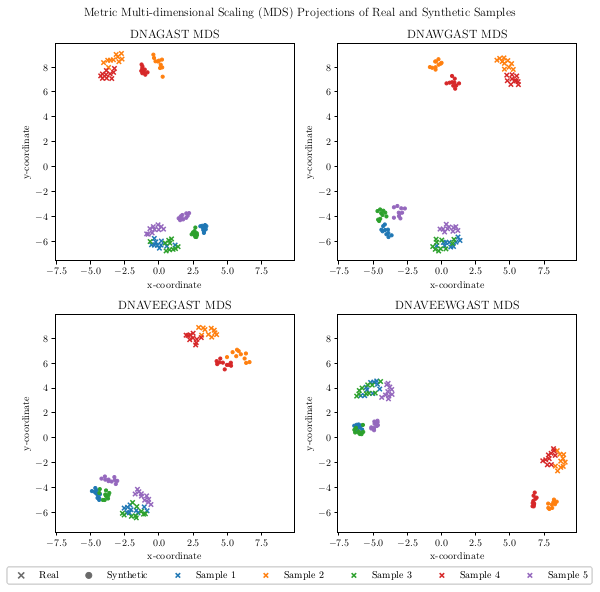

In [235]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

legend_points = []

legend_points.append(axs[0][0].scatter([], [], color="dimgrey", marker='x'))
legend_points.append(axs[0][0].scatter([], [], color="dimgrey"))

for i, key in enumerate(models):

    ax = axs[i // 2][i % 2]

    pca = pcas[i]
    real, fake = pca[:len(control_samples[0])], pca[len(control_samples[0]):]
    cmap = plt.get_cmap("tab10")
    scale = ax_max - ax_min
    points = []
    for j, offset in enumerate(range(0, len(real), control_subsamples_per_sample)):
        data = real[offset:offset + control_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), marker='x', s=20)
        if i == 0:
            legend_points.append(points)
    for j, offset in enumerate(range(0, len(fake), test_subsamples_per_sample)):
        data = fake[offset:offset + test_subsamples_per_sample]
        points = ax.scatter(*data.T, color=cmap(j), s=10)
        if i == 0:
            legend_points.append(points)
    # ax.legend(
    #     ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
    #     loc="center left",
    #     bbox_to_anchor=(1.0, 0.5))
    # ax.set_title(f"MDS of Chamfer Distances Between DNA Samples (epoch {runs['dnawgast'].summary.epoch})")
    ax.set_title(f"{key.upper()} MDS")
    pad = 0.05*scale
    ax.set_xlim((ax_min - pad, ax_max + pad))
    ax.set_ylim((ax_min - pad, ax_max + pad))
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    fig.suptitle("Metric Multi-dimensional Scaling (MDS) Projections of Real and Synthetic Samples")
    fig.legend(
        legend_points,
        ["Real", "Synthetic"] + [f"Sample {i+1}" for i in range(len(samples))],
        ncol=len(legend_points),
        loc="lower center",
        bbox_to_anchor=(0.5, -0.03))
    fig.tight_layout()
    fig.savefig(f"../plots/dnagast_mds.pgf", bbox_inches="tight")
    fig.show()

In [236]:
stresses = {}
extended_distance_matrices = {}

for key in models:
    stress_list = []
    for i in range(N):
        print(f"\r{key}: {i+1}/{N}", end="")
        stress_list.append(mds_stress_analysis(distance_matrices[key][i], dims=dnabert_encoder.base.embed_dim)[1])
    stresses[key] = np.array(stress_list)

dnaveewgast: 10/10

In [237]:
data = np.array(stresses["dnawgast"])
data.shape

(10, 8)

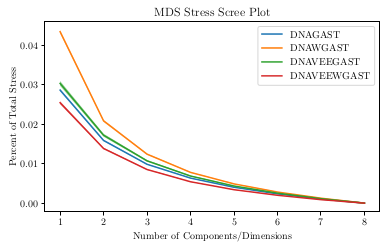

In [254]:
plt.figure(figsize=(6, 3.5))
for key, values in stresses.items():
    x = np.arange(values.shape[-1]) + 1
    mean = np.mean(values, axis=0)
    std = np.std(values, axis=0)

    ci = 1.96 * std/np.sqrt(N)

    plt.plot(x, mean, label=key.upper())
    plt.fill_between(x, mean - ci, mean + ci, alpha=0.5)
plt.title("MDS Stress Scree Plot")
plt.legend()
plt.xlabel("Number of Components/Dimensions")
plt.ylabel("Percent of Total Stress")
plt.savefig("../plots/dnagast_mds_scree.pgf")
plt.show()

In [242]:
def partition_distance_matrix(distance_matrix):
        n = control_subsamples_per_sample
        m = test_subsamples_per_sample
        N = n*len(samples)
        dist_mats = np.empty((len(samples), n+m, n+m))
        for i in range(0, len(samples)):
            # Pull out matrix quadrants for common sample distances
            # A/C = real, B/D = fake
            A = distance_matrix[i*n:(i+1)*n,     i*n:(i+1)*n]     # top-left
            B = distance_matrix[i*n:(i+1)*n,     N+i*m:N+(i+1)*m] # top-right
            C = distance_matrix[N+i*m:N+(i+1)*m, i*n:(i+1)*n]     # bottom-left
            D = distance_matrix[N+i*m:N+(i+1)*m, N+i*m:N+(i+1)*m] # bottom-right

            # Merge into a single distance matrix
            AB = np.concatenate((A, B), axis=1)
            CD = np.concatenate((C, D), axis=1)
            dist_mats[i] = np.concatenate((AB, CD), axis=0)
        return dist_mats

def compute_compactness(distance_matrices):
        n = control_subsamples_per_sample
        fns = {"amean": np.mean, "gmean": stats.gmean, "hmean": stats.hmean}
        results = [{l: [] for l in fns} for i in range(len(samples))]
        for distance_matrix in distance_matrices:
            dist_mats = partition_distance_matrix(distance_matrix)
            for i in range(len(samples)):
                d = dist_mats[i]

                real_to_real_subsamples = d[:n,:n][np.triu_indices(n, 1)]
                fake_to_fake_subsamples = d[n:,n:][np.triu_indices(len(dist_mats[0]) - n, 1)]

                for key, fn in fns.items():
                    real = fn(real_to_real_subsamples)
                    fake = fn(fake_to_fake_subsamples)
                    results[i][key].append(real / fake)
        return results

def compute_spread(distance_matrices):
    n = control_subsamples_per_sample*len(samples)
    fns = {"amean": np.mean, "gmean": stats.gmean, "hmean": stats.hmean}
    results = {l: [] for l in fns}

    for distance_matrix in distance_matrices:
        real_to_real_subsamples = distance_matrix[:n,:n][np.triu_indices(n, 1)]
        fake_to_fake_subsamples = distance_matrix[n:,n:][np.triu_indices(len(distance_matrix) - n, 1)]

        for key, fn in fns.items():
            real = fn(real_to_real_subsamples)
            fake = fn(fake_to_fake_subsamples)
            results[key].append(real / fake)
    return results

In [243]:
compactness = {m: compute_compactness(distance_matrices[m]) for m in models}
spread = {m: compute_spread(distance_matrices[m]) for m in models}

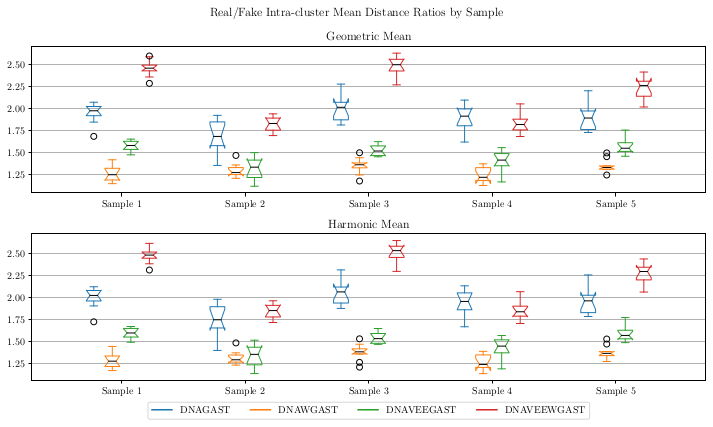

In [252]:
x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(models)
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(10, 6))
plt.suptitle("Real/Fake Intra-cluster Mean Distance Ratios by Sample")
plt.subplot(211)
for i, model in enumerate(models):
    data = [compactness[model][j]["gmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))
plt.title("Geometric Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

plt.subplot(212)
for i, model in enumerate(models):
    data = [compactness[model][j]["hmean"] for j in range(len(samples))]
    boxplot = plt.boxplot(data, positions=x - group_width/2 + (2*i + 1)*width/2, notch=True, widths=width * 0.8)
    plt.setp(boxplot["boxes"], color=cmap(i))
    plt.setp(boxplot["whiskers"], color=cmap(i))
    plt.setp(boxplot["caps"], color=cmap(i))
    plt.setp(boxplot["medians"], color="#000000")
    plt.setp(boxplot["fliers"], color=cmap(i))

plt.title("Harmonic Mean")
plt.xticks(x, [f"Sample {j+1}" for j in range(len(samples))])
plt.grid(axis='y')

legend_labels = []
for model in models:
    legend_labels.append(plt.plot([], label=model.upper()))

plt.legend(loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig("../plots/dnagast_intra_distance.pgf", bbox_inches="tight")
plt.show()

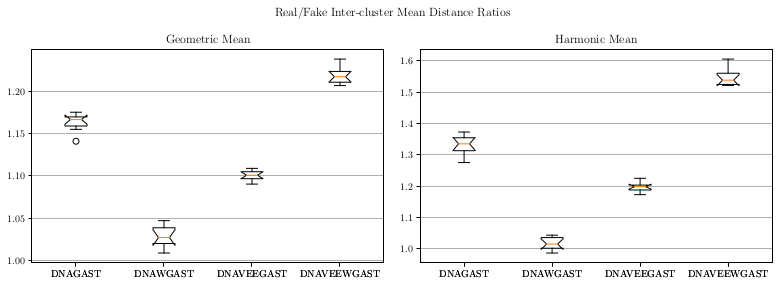

In [251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharex=True)

ax1.boxplot([spread[m]["gmean"] for m in models], notch=True, vert=True, labels=[m.upper() for m in models], widths=0.25)
ax1.set_title("Geometric Mean")
ax1.grid(axis='y')

ax2.boxplot([spread[m]["hmean"] for m in models], notch=True, vert=True, labels=[m.upper() for m in models], widths=0.25)
ax2.set_title("Harmonic Mean")
ax2.grid(axis='y')

fig.suptitle("Real/Fake Inter-cluster Mean Distance Ratios")
fig.tight_layout()
fig.savefig("../plots/dnagast_inter_distance.pgf")
fig.show()

In [44]:
compactness_artifacts = {}
spread_artifacts = {}
for key, run in runs.items():
    print(key)
    compactness_artifacts[key] = {}
    spread_artifacts[key] = {}
    for artifact in run.logged_artifacts():
        if "compactness_gmean" in artifact.name:
            compactness_artifacts[key]["gmean"] = artifact
        elif "compactness_hmean" in artifact.name:
            compactness_artifacts[key]["hmean"] = artifact
        elif "spread_gmean" in artifact.name:
            spread_artifacts[key]["gmean"] = artifact
        elif "spread_hmean" in artifact.name:
            spread_artifacts[key]["hmean"] = artifact

dnagast
dnawgast
dnaveegast
dnaveewgast


In [45]:
compactness_data = {}
spread_data = {}
for key in models:
    print(key)
    compactness_data[key] = {}
    spread_data[key] = {}

    # gmean compactness
    path = compactness_artifacts[key]["gmean"].download(f"./tmp/{key}/gmean")
    with open(os.path.join(path, "compactness_gmean.table.json")) as f:
        data = json.load(f)
        compactness_data[key]["gmean"] = pd.DataFrame(data=data["data"], columns=data["columns"])

    # hmean compactness
    path = compactness_artifacts[key]["hmean"].download(f"./tmp/{key}/hmean")
    with open(os.path.join(path, "compactness_hmean.table.json")) as f:
        data = json.load(f)
        compactness_data[key]["hmean"] = pd.DataFrame(data=data["data"], columns=data["columns"])

    # gmean spread
    path = spread_artifacts[key]["gmean"].download(f"./tmp/{key}/gmean")
    with open(os.path.join(path, "spread_gmean.table.json")) as f:
        data = json.load(f)
        spread_data[key]["gmean"] = pd.DataFrame(data=data["data"], columns=data["columns"])

    # hmean spread
    path = spread_artifacts[key]["hmean"].download(f"./tmp/{key}/hmean")
    with open(os.path.join(path, "spread_hmean.table.json")) as f:
        data = json.load(f)
        spread_data[key]["hmean"] = pd.DataFrame(data=data["data"], columns=data["columns"])

dnagast
dnawgast
dnaveegast
dnaveewgast


In [46]:
compactness_data[key]["gmean"]

,Real 1,Fake 1,Real/Fake Ratio 1,Real 2,Fake 2,Real/Fake Ratio 2,Real 3,Fake 3,Real/Fake Ratio 3,Real 4,Fake 4,Real/Fake Ratio 4,Real 5,Fake 5,Real/Fake Ratio 5
0,2.076144,5.297346,0.391922,2.001346,4.197217,0.476827,2.14547,4.737832,0.452838,1.905806,4.852212,0.392771,2.216527,4.453680,0.497684
1,2.076144,5.603131,0.370533,2.001346,5.507965,0.363355,2.14547,5.618134,0.381883,1.905806,6.027078,0.316207,2.216527,6.443850,0.343976
2,2.076144,4.825969,0.430203,2.001346,5.572495,0.359147,2.14547,4.464425,0.480570,1.905806,5.530957,0.344571,2.216527,5.703167,0.388648
3,2.076144,8.097151,0.256404,2.001346,12.497309,0.160142,2.14547,11.075691,0.193710,1.905806,17.074757,0.111615,2.216527,23.341133,0.094962
4,2.076144,4.205277,0.493700,2.001346,5.428721,0.368659,2.14547,3.549505,0.604442,1.905806,4.689917,0.406363,2.216527,5.344561,0.414726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2.076144,0.910005,2.281465,2.001346,1.101738,1.816535,2.14547,1.272382,1.686184,1.905806,1.079503,1.765448,2.216527,1.107309,2.001725
428,2.076144,0.883100,2.350973,2.001346,1.114483,1.795762,2.14547,1.074873,1.996022,1.905806,1.081406,1.762341,2.216527,0.899077,2.465336
429,2.076144,0.989908,2.097310,2.001346,0.963467,2.077233,2.14547,1.277345,1.679633,1.905806,1.029725,1.850792,2.216527,1.002695,2.210570
430,2.076144,0.910151,2.281100,2.001346,0.965922,2.071953,2.14547,1.093077,1.962781,1.905806,0.924402,2.061663,2.216527,0.918343,2.413616


In [47]:
compactness_ratios = {g: [[] for _ in samples] for g in ("gmean", "hmean")}
for key in compactness_data:
    for group in compactness_ratios:
        table = compactness_data[key][group]
        for i in range(len(samples)):
            data = table[f"Real/Fake Ratio {i + 1}"]
            ratio = data[len(data) - 1]
            compactness_ratios[group][i].append(ratio)
for group in compactness_ratios:
    compactness_ratios[group] = np.array(compactness_ratios[group]).T

In [48]:
compactness_ratios["gmean"].shape

(4, 5)

In [49]:
spread_ratios = {g: [] for g in ("gmean", "hmean")}
for key in spread_data:
    for group in spread_ratios:
        table = spread_data[key][group]
        data = table["Real/Fake Ratio"]
        ratio = data[len(data) - 1]
        spread_ratios[group].append(ratio)
for group in spread_ratios:
    spread_ratios[group] = np.array(spread_ratios[group])

In [50]:
spread_ratios["gmean"].shape

(4,)

In [51]:
labels = [f"Sample {i+1}" for i in range(len(samples))]

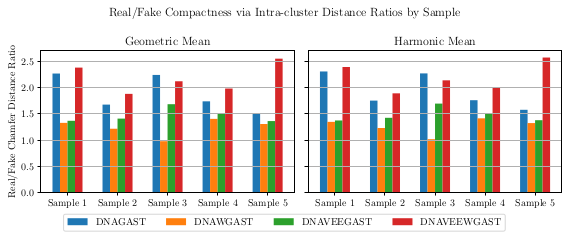

In [52]:
gmeans = compactness_ratios["gmean"]
hmeans = compactness_ratios["hmean"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

x = np.arange(len(samples))
group_width = 0.6
width = group_width / len(gmeans)

rects = []
for i, mean in enumerate(gmeans):
    rects.append(ax1.bar(x + (2*i + 1)*width/2 - group_width/2, mean, width))
ax1.set_ylabel("Real/Fake Chamfer Distance Ratio")
ax1.set_xticks(x, labels)
ax1.set_title("Geometric Mean")
ax1.grid(axis='y')

for i, mean in enumerate(hmeans):
    ax2.bar(x + (2*i + 1)*width/2 - group_width/2, mean, width)
# ax2.set_ylabel("Real/Fake Chamfer Distance Ratio")
ax2.set_xticks(x, labels)
ax2.set_title("Harmonic Mean")
ax2.grid(axis='y')

# ax1.legend()
# handles, labels = ax1.get_legend_handles_labels()

# fig.legend(handles, labels, loc="lower center")
fig.suptitle("Real/Fake Compactness via Intra-cluster Distance Ratios by Sample")
fig.legend(rects, [m.upper() for m in models], loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.08))
fig.tight_layout()
fig.savefig("./tmp/compactness.pgf", bbox_inches="tight")
fig.show()

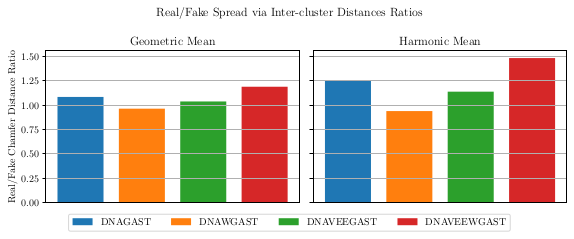

In [53]:
gmeans = spread_ratios["gmean"]
hmeans = spread_ratios["hmean"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

x = np.arange(len(models))
width = 0.75

rects = []
for i, mean in enumerate(gmeans):
    rects.append(ax1.bar(x[i], mean, width))
ax1.set_ylabel("Real/Fake Chamfer Distance Ratio")
ax1.set_xticks([])
ax1.set_title("Geometric Mean")
ax1.grid(axis='y')

for i, mean in enumerate(hmeans):
    ax2.bar(x[i], mean, width)
ax2.set_xticks([])
ax2.set_title("Harmonic Mean")
ax2.grid(axis='y')

# ax1.legend()
# handles, labels = ax1.get_legend_handles_labels()

# fig.legend(handles, labels, loc="lower center")
fig.suptitle("Real/Fake Spread via Inter-cluster Distances Ratios")
fig.legend(rects, [m.upper() for m in models], loc="lower center", ncol=len(models), bbox_to_anchor=(0.5, -0.08))
fig.tight_layout()
fig.savefig("./tmp/spread.pgf", bbox_inches="tight")
fig.show()